In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.set_random_seed(1)

import numpy as np
import scipy
import h5py
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.keras.optimizers import Adam,RMSprop 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Flatten, Dense,Conv2D, MaxPooling2D,Dropout,BatchNormalization 
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
 

C:\Users\ali\Anaconda3\envs\tfgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


STEP 2
Define the Data Source. 
This may differ, and you should modify it to point to your correct paths

In [15]:
# Define the image Source. 
STARTDIR='C:\\data\\clothes\\'


train_data_dir = os.path.join(STARTDIR,'train')
validation_data_dir = os.path.join(STARTDIR,'validation')
userCreatedImages_dir = os.path.join(STARTDIR,'UserData\\')
model_dir = os.path.join(STARTDIR,'model_ourclothes.json')
weights_dir=os.path.join(STARTDIR,'weights_ourclothes.h5')

 
# Initialize the variables
image_width, image_height = 150, 150
nb_train_samples = 1366
nb_validation_samples = 157
epochs =200
batch_size = 60
num_classes=6

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./ 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical')

print(train_generator.class_indices.keys())

Found 1366 images belonging to 6 classes.
Found 157 images belonging to 6 classes.
dict_keys(['hat', 'pant', 'shirt', 'shoes', 'skirt', 'socks'])


In [40]:
optimizer = RMSprop(lr=0.0001,decay=1e-6)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(image_width, image_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(50,   activation='relu'))
model.add(Dropout(0.25))
 

model.add(Dense(num_classes,   activation='softmax'))
model.compile(loss='categorical_crossentropy',  optimizer=optimizer,  metrics=['accuracy'])

print(model.summary()) 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_37 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_38 (Activation)   (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 36, 36, 64)        0         
__________

In [41]:
checkpointer = ModelCheckpoint(filepath=weights_dir,
   verbose=1, 
   monitor='val_acc',
   save_best_only=True,
   mode='max')

tensorBoardPointer = TensorBoard(
 
    log_dir=os.path.join(STARTDIR,'logs') , 
    histogram_freq=0, 
    write_graph=True,
    write_images=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.001)

with tf.device('/gpu:0'):
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples,
        callbacks=[checkpointer ,tensorBoardPointer,reduce_lr ])   


model_json = model.to_json()
with open(model_dir, "w") as json_file:
    json_file.write(model_json)


Epoch 1/200
21/22 [===========================>..] - ETA: 0s - loss: 1.7950 - acc: 0.2135
Epoch 00001: val_acc improved from -inf to 0.20331, saving model to C:\data\clothes\model_ourclothes.h5
22/22 [==============================] - 21s 940ms/step - loss: 1.7926 - acc: 0.2144 - val_loss: 1.7800 - val_acc: 0.2033
Epoch 2/200
21/22 [===========================>..] - ETA: 0s - loss: 1.7786 - acc: 0.2148
Epoch 00002: val_acc improved from 0.20331 to 0.25438, saving model to C:\data\clothes\model_ourclothes.h5
22/22 [==============================] - 20s 901ms/step - loss: 1.7786 - acc: 0.2171 - val_loss: 1.7628 - val_acc: 0.2544
Epoch 3/200
21/22 [===========================>..] - ETA: 0s - loss: 1.7500 - acc: 0.2430
Epoch 00003: val_acc improved from 0.25438 to 0.26119, saving model to C:\data\clothes\model_ourclothes.h5
22/22 [==============================] - 20s 888ms/step - loss: 1.7483 - acc: 0.2432 - val_loss: 1.7415 - val_acc: 0.2612
Epoch 4/200
21/22 [===========================

Epoch 31/200
21/22 [===========================>..] - ETA: 0s - loss: 1.4137 - acc: 0.4335
Epoch 00031: val_acc improved from 0.63692 to 0.63704, saving model to C:\data\clothes\model_ourclothes.h5
22/22 [==============================] - 19s 857ms/step - loss: 1.4184 - acc: 0.4312 - val_loss: 1.3704 - val_acc: 0.6370
Epoch 32/200
21/22 [===========================>..] - ETA: 0s - loss: 1.4041 - acc: 0.4302
Epoch 00032: val_acc did not improve
22/22 [==============================] - 18s 808ms/step - loss: 1.4029 - acc: 0.4341 - val_loss: 1.3366 - val_acc: 0.5479
Epoch 33/200
21/22 [===========================>..] - ETA: 0s - loss: 1.3729 - acc: 0.4354
Epoch 00033: val_acc improved from 0.63704 to 0.64360, saving model to C:\data\clothes\model_ourclothes.h5
22/22 [==============================] - 17s 794ms/step - loss: 1.3689 - acc: 0.4384 - val_loss: 1.3141 - val_acc: 0.6436
Epoch 34/200
21/22 [===========================>..] - ETA: 0s - loss: 1.4294 - acc: 0.4317
Epoch 00034: val_ac

Epoch 93/200
21/22 [===========================>..] - ETA: 0s - loss: 1.0071 - acc: 0.6187
Epoch 00093: val_acc did not improve
22/22 [==============================] - 16s 737ms/step - loss: 1.0127 - acc: 0.6186 - val_loss: 0.9227 - val_acc: 0.7265
Epoch 94/200
21/22 [===========================>..] - ETA: 0s - loss: 1.0232 - acc: 0.6149
Epoch 00094: val_acc did not improve
22/22 [==============================] - 21s 953ms/step - loss: 1.0171 - acc: 0.6180 - val_loss: 0.8284 - val_acc: 0.7643
Epoch 95/200
21/22 [===========================>..] - ETA: 0s - loss: 1.0308 - acc: 0.5957
Epoch 00095: val_acc did not improve
22/22 [==============================] - 20s 928ms/step - loss: 1.0326 - acc: 0.5936 - val_loss: 0.9041 - val_acc: 0.7643
Epoch 96/200
21/22 [===========================>..] - ETA: 0s - loss: 1.0097 - acc: 0.6048
Epoch 00096: val_acc did not improve
22/22 [==============================] - 20s 893ms/step - loss: 1.0102 - acc: 0.6046 - val_loss: 0.8486 - val_acc: 0.7834


Epoch 126/200
21/22 [===========================>..] - ETA: 0s - loss: 0.9173 - acc: 0.6587
Epoch 00126: val_acc did not improve
22/22 [==============================] - 17s 769ms/step - loss: 0.9098 - acc: 0.6583 - val_loss: 0.7111 - val_acc: 0.7839
Epoch 127/200
21/22 [===========================>..] - ETA: 0s - loss: 0.9308 - acc: 0.6547
Epoch 00127: val_acc did not improve
22/22 [==============================] - 18s 809ms/step - loss: 0.9260 - acc: 0.6522 - val_loss: 0.7136 - val_acc: 0.7647
Epoch 128/200
21/22 [===========================>..] - ETA: 0s - loss: 0.9429 - acc: 0.6547
Epoch 00128: val_acc did not improve
22/22 [==============================] - 17s 785ms/step - loss: 0.9477 - acc: 0.6522 - val_loss: 0.7336 - val_acc: 0.7705
Epoch 129/200
21/22 [===========================>..] - ETA: 0s - loss: 0.9401 - acc: 0.6603
Epoch 00129: val_acc improved from 0.81518 to 0.82794, saving model to C:\data\clothes\model_ourclothes.h5
22/22 [==============================] - 18s 818

Epoch 191/200
21/22 [===========================>..] - ETA: 0s - loss: 0.8037 - acc: 0.6993
Epoch 00191: val_acc did not improve
22/22 [==============================] - 19s 876ms/step - loss: 0.8099 - acc: 0.6978 - val_loss: 0.6015 - val_acc: 0.8148
Epoch 192/200
21/22 [===========================>..] - ETA: 0s - loss: 0.8431 - acc: 0.6893
Epoch 00192: val_acc did not improve
22/22 [==============================] - 19s 857ms/step - loss: 0.8449 - acc: 0.6876 - val_loss: 0.6093 - val_acc: 0.8093
Epoch 193/200
21/22 [===========================>..] - ETA: 0s - loss: 0.8018 - acc: 0.7095
Epoch 00193: val_acc did not improve
22/22 [==============================] - 19s 861ms/step - loss: 0.7996 - acc: 0.7114 - val_loss: 0.6629 - val_acc: 0.7833
Epoch 194/200
21/22 [===========================>..] - ETA: 0s - loss: 0.7886 - acc: 0.7008
Epoch 00194: val_acc did not improve
22/22 [==============================] - 18s 818ms/step - loss: 0.7820 - acc: 0.7031 - val_loss: 0.5622 - val_acc: 0.8

Text(0.5,1,'Accuracy Curves')

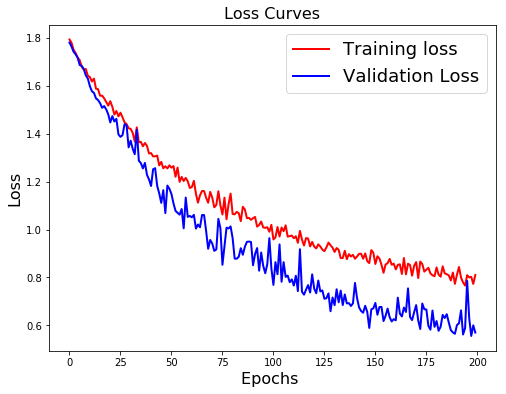

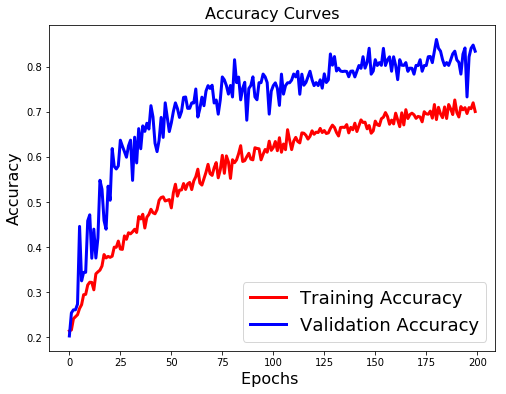

In [47]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 

plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

skirt


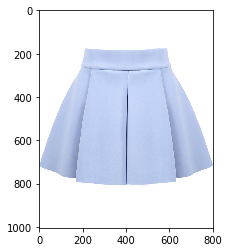

skirt


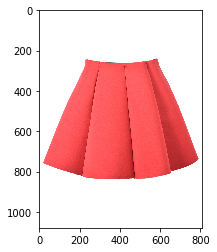

skirt


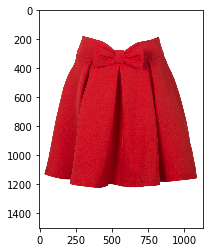

skirt


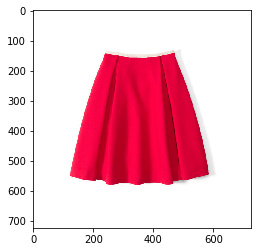

skirt


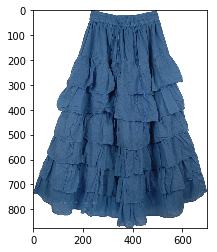

skirt


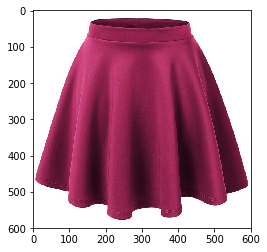

skirt


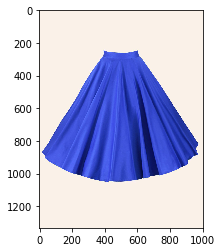

skirt


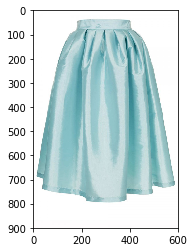

skirt


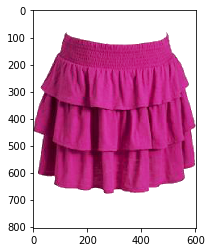

skirt


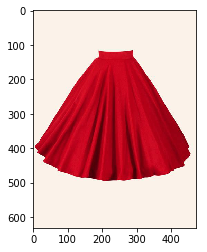

skirt


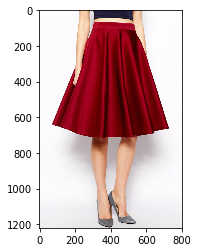

hat


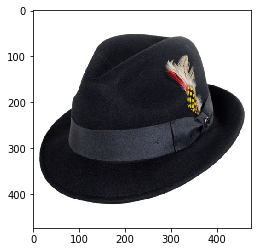

hat


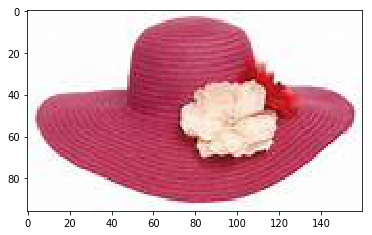

hat


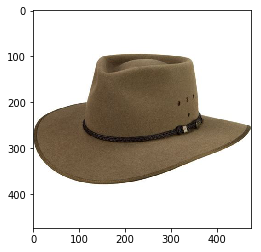

shirt


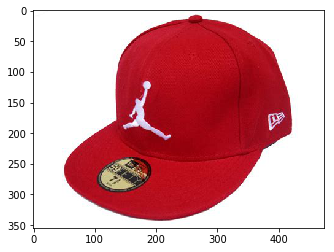

hat


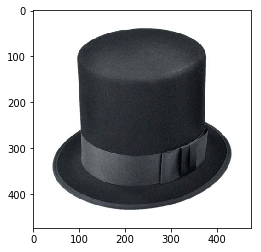

hat


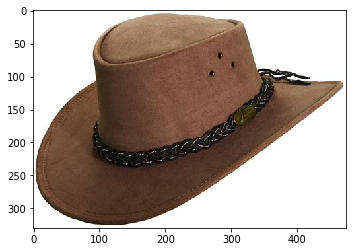

shoes


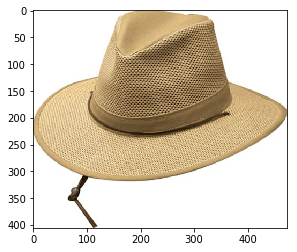

hat


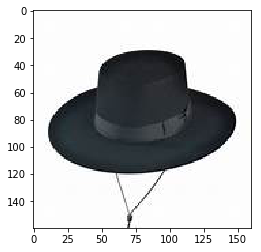

hat


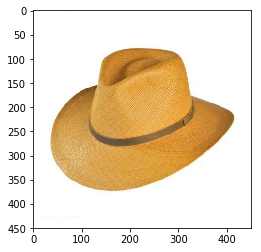

hat


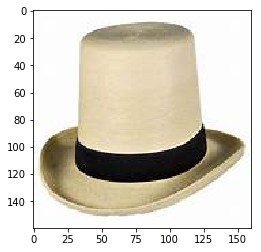

pant


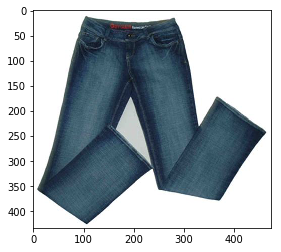

pant


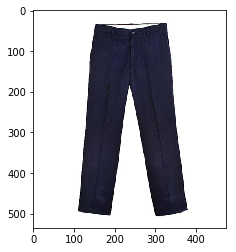

pant


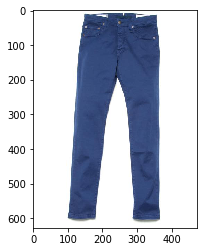

pant


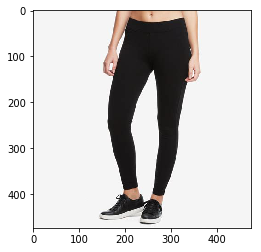

pant


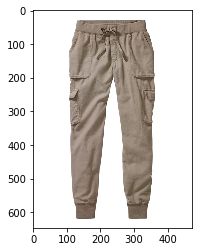

pant


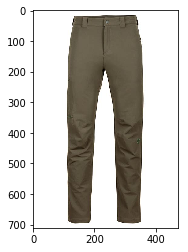

pant


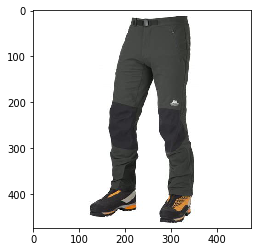

pant


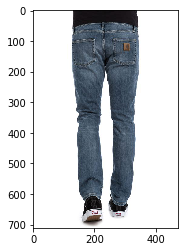

pant


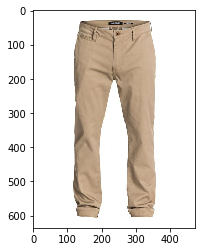

pant


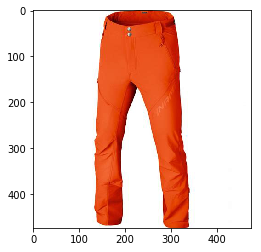

pant


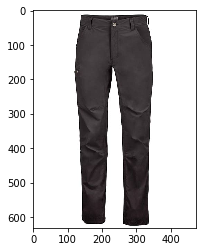

pant


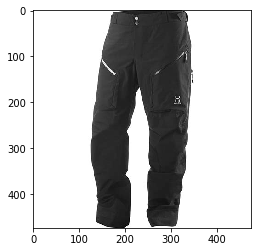

pant


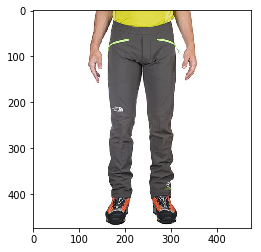

shirt


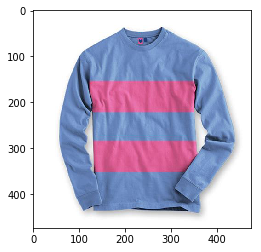

shirt


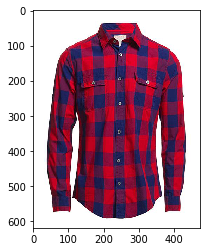

shirt


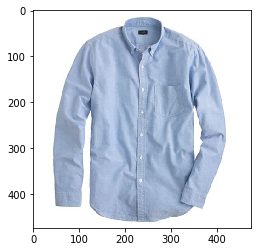

shirt


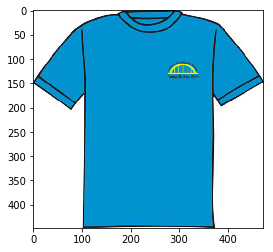

shirt


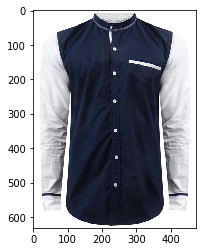

shirt


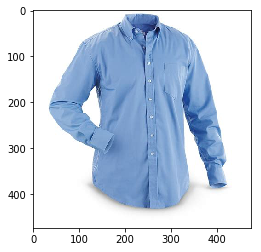

shirt


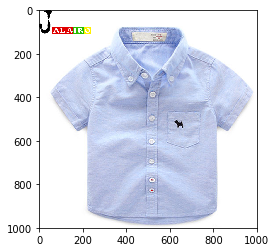

shirt


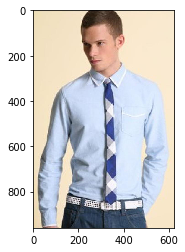

shoes


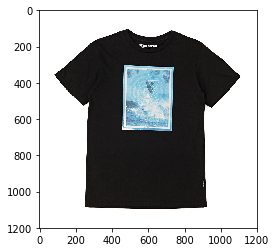

shirt


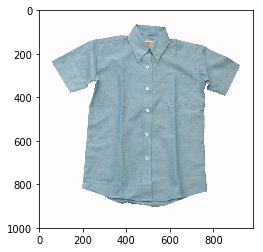

skirt


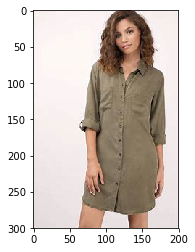

shirt


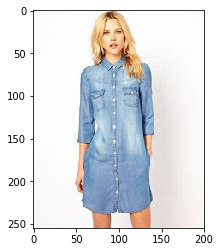

socks


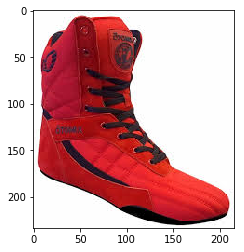

socks


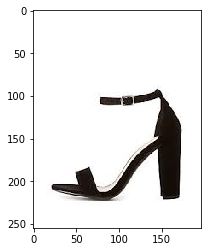

shoes


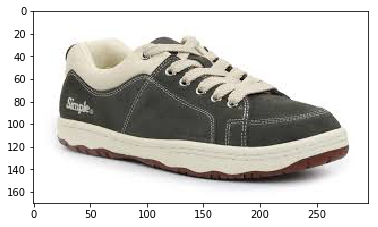

skirt


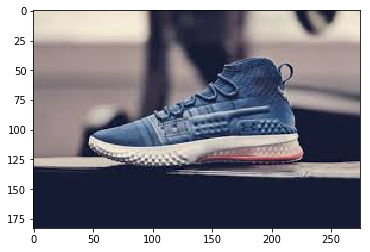

shoes


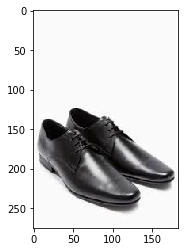

shoes


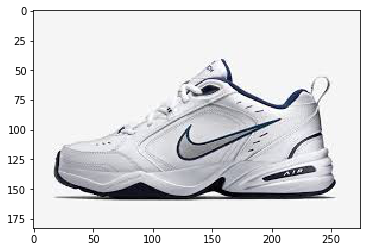

shoes


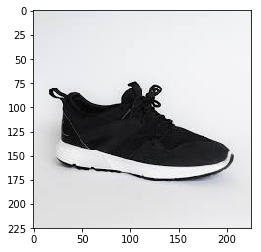

shoes


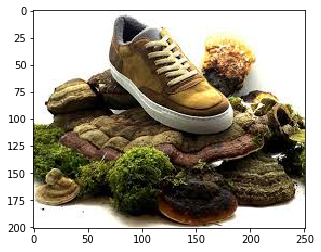

shoes


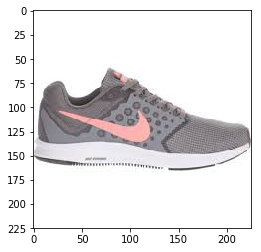

shoes


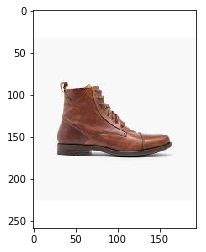

shoes


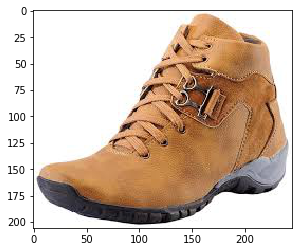

shoes


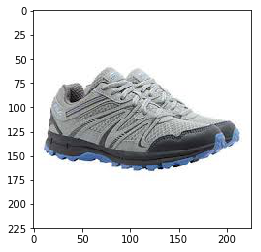

skirt


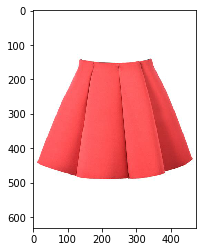

skirt


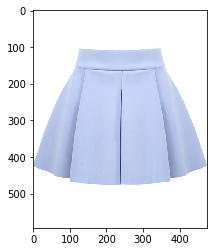

skirt


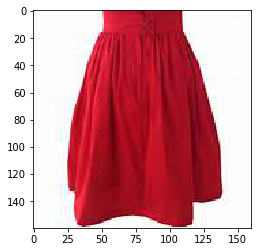

skirt


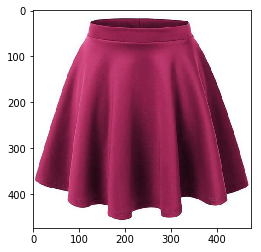

socks


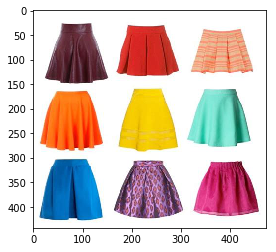

skirt


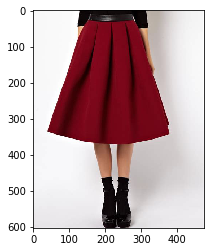

shoes


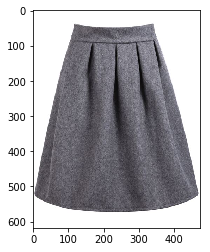

skirt


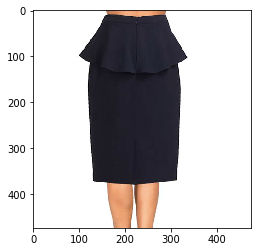

skirt


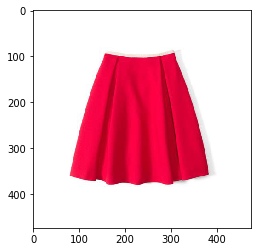

hat


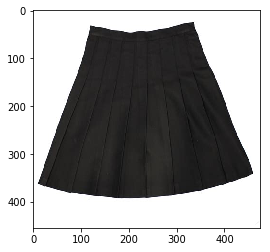

shoes


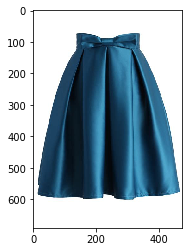

skirt


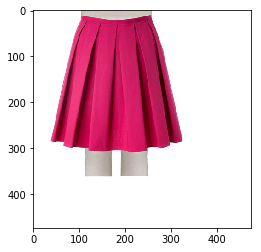

shirt


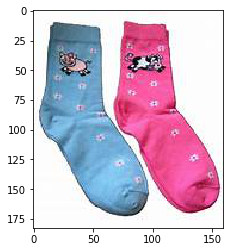

socks


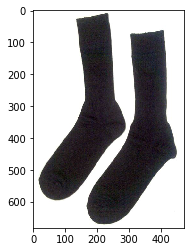

socks


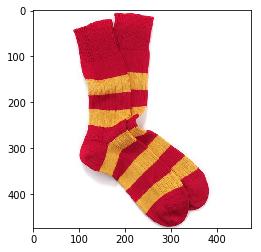

socks


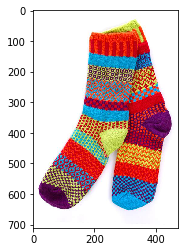

socks


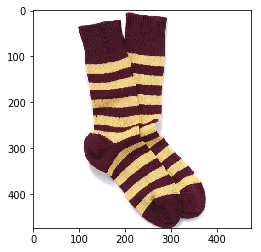

socks


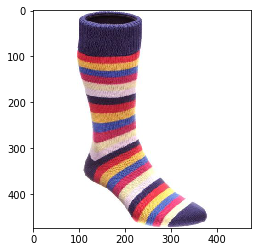

socks


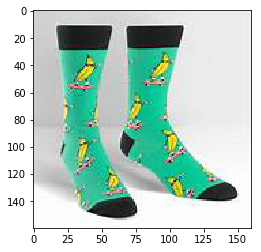

socks


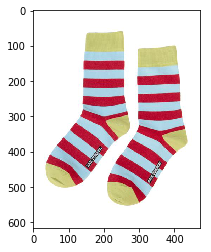

shirt


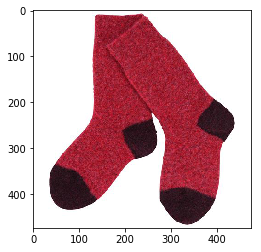

socks


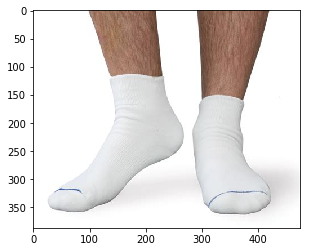

socks


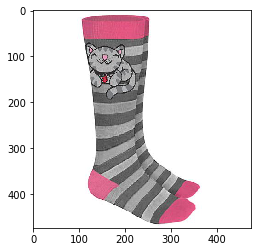

socks


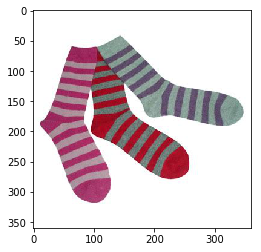

shirt


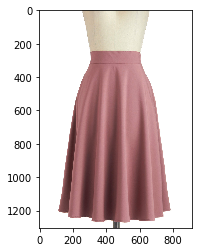

In [45]:
path = userCreatedImages_dir
files = os.listdir(path)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())


for file in files:
    pred=-1
    t_image= image.load_img(path + file )
    test_image = image.load_img(path + file, target_size=(image_height, image_width))
    test_image = image.img_to_array(test_image)
    test_image /= 255
    test_image = np.expand_dims(test_image, axis=0)
    predictions = model.predict_classes(test_image)
    a = predictions[0]
    print(labels[a])
    plt.imshow(t_image)
    plt.show()  